In [16]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# # Set seeds
# def seed_everything(seed=0):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     tf.random.set_seed(seed)

# SEED = 0
# seed_everything(SEED)

In [3]:
# Parameters
BATCH_SIZE = 32
HEIGHT = 224
WIDTH = 224
SEED = 123
EPOCHS = 50

In [4]:
# Path of the dataset

# local
INPUT_PATH = './paddy-disease-classification/'
# kaggle
# INPUT_PATH = '../input/paddy-disease-classification/'

TRAIN_DATA_DIR = INPUT_PATH + 'train_images/'
TEST_DATA_DIR = INPUT_PATH + 'test_images/'

* ImageDataGenerator는 더이상 안쓰인다고 함
* image_dataset_from_directory 가 정확성이 비슷하면서 속도는 더 빠르다고 함
* https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [6]:
class_names = train_ds.class_names
n_classes = len(class_names)
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


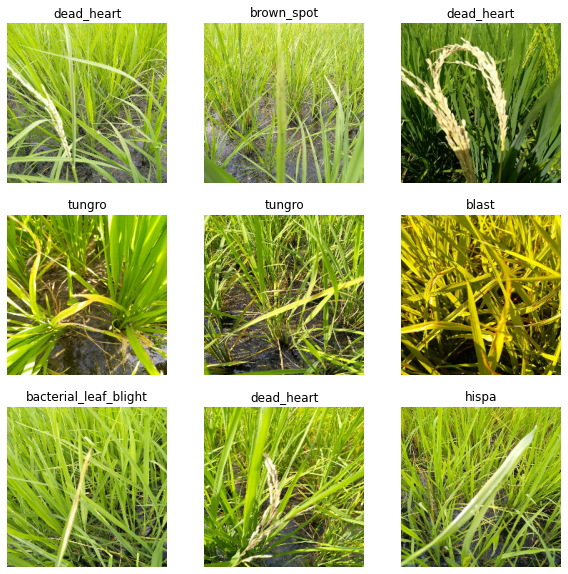

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        # plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
plt.show()

### 이미지 전처리 레이어
* https://www.tensorflow.org/guide/keras/preprocessing_layers

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor=0.1),
    layers.RandomFlip('horizontal'),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomContrast(factor=0.1)
])

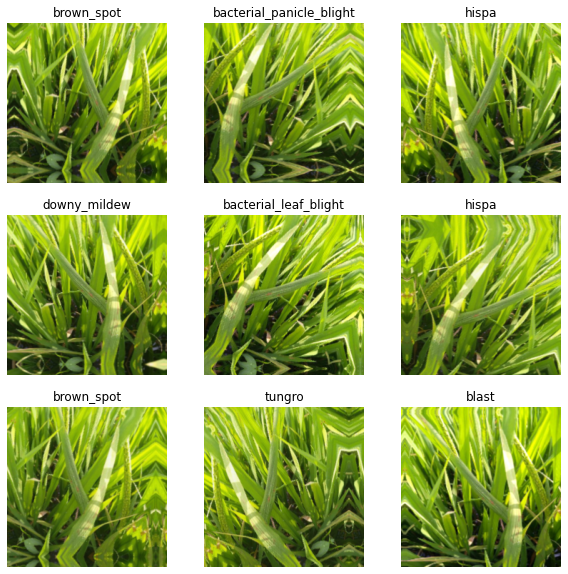

In [9]:
plt.figure(figsize=(10, 10))
for image, labels in train_ds.take(1):
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()

### tensorflow dataset pipeline optimize
* https://www.tensorflow.org/guide/data_performance?hl=ko

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare_dataset(ds):
    def input_preprocess(image, label):
        label = tf.one_hot(label, n_classes)
        return image, label
    ds = ds.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

In [11]:
train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)

* Global Average Pooling
    * MaxPooling 보다 급격하게 feature의 수를 줄인다.
    * GAP의 목적은 feature를 1차원 벡터로 만들기 위함.
    * (height, width, channel) -> (channel,)
    * 그냥 Flatten 해서 사용하면 공간정보도 잃어버리고, 가중치도 너무 많이 사용된다.
* GlorotUniform
    * Draws samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / (fan_in + fan_out))
    * (fan_in is the number of input units in the weight tensor and fan_out is the number of output units).
* regularization
    * 과대적합 피하는 처리과정
    * weight regularization (가중치 규제): 네트워크의 복잡도에 제한을 도어 가중치가 작은 값을 가지도록 강제하는 것
        * L1 regularization: 가중치의 절댓값에 비례하는 비용이 추가됨 (가중치의 L1 norm)
        * L2 regularization(=weight decay): 가중치의 제곱에 비례하는 비용이 추가됨 (가중치의 L2 norm)
    * https://keras.io/api/layers/regularizers/

In [12]:
def create_model(n_classes, fine_tune=0):
    inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = data_augmentation(x)
    conv_base = tf.keras.applications.VGG16(
        include_top=False,
        input_tensor=x,
        weights='imagenet'
    )

    # Freeze the pretrained weights
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name='gap')(conv_base.output)
    x = layers.BatchNormalization()(x)

    initializer = tf.keras.initializers.GlorotUniform()
    x = tf.keras.layers.Dense(
        256,
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
        kernel_initializer=initializer,
        activation='relu'
    )(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = layers.Dense(
        n_classes,
        kernel_initializer=initializer,
        activation='softmax',
        name='pred'
    )(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name='VGG16')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = create_model(n_classes, 2)

In [13]:
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856 

In [14]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(
    filepath='vgg16_best_weights.hdf5',
    save_best_only=True,
    verbose=0
)

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min'
)

rlrop = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [15]:
%%time

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[tl_checkpoint_1, early_stop, rlrop],
    verbose=2
)

Epoch 1/50
261/261 - 56s - loss: 1.9565 - accuracy: 0.4464 - val_loss: 2.1324 - val_accuracy: 0.3465 - lr: 0.0010 - 56s/epoch - 213ms/step
Epoch 2/50
261/261 - 50s - loss: 1.3976 - accuracy: 0.6032 - val_loss: 1.2973 - val_accuracy: 0.6261 - lr: 0.0010 - 50s/epoch - 190ms/step
Epoch 3/50
261/261 - 49s - loss: 1.1368 - accuracy: 0.6844 - val_loss: 1.3113 - val_accuracy: 0.6194 - lr: 0.0010 - 49s/epoch - 187ms/step
Epoch 4/50
261/261 - 49s - loss: 1.0042 - accuracy: 0.7290 - val_loss: 1.1970 - val_accuracy: 0.6848 - lr: 0.0010 - 49s/epoch - 188ms/step
Epoch 5/50
261/261 - 49s - loss: 0.8903 - accuracy: 0.7574 - val_loss: 0.9421 - val_accuracy: 0.7641 - lr: 0.0010 - 49s/epoch - 188ms/step
Epoch 6/50
261/261 - 49s - loss: 0.8252 - accuracy: 0.7795 - val_loss: 0.9767 - val_accuracy: 0.7544 - lr: 0.0010 - 49s/epoch - 188ms/step
Epoch 7/50
261/261 - 48s - loss: 0.7433 - accuracy: 0.8088 - val_loss: 0.7641 - val_accuracy: 0.8078 - lr: 0.0010 - 48s/epoch - 183ms/step
Epoch 8/50
261/261 - 46s - 

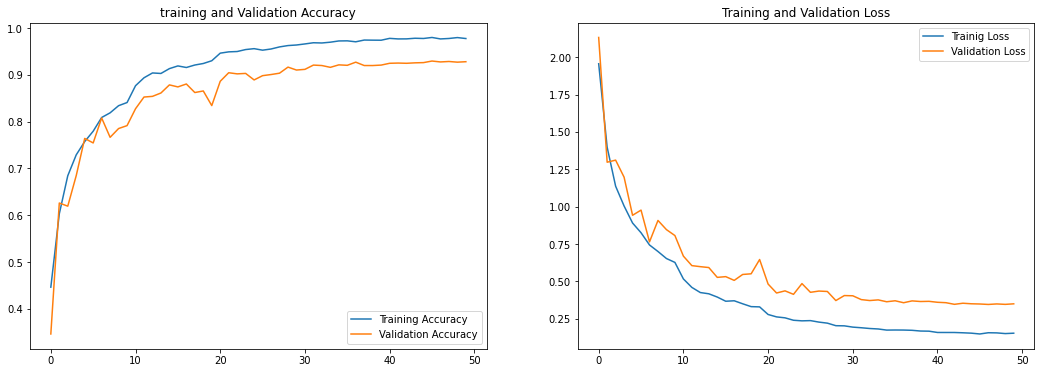

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Trainig Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model.load_weights('./vgg16_best_weights.hdf5')

In [20]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA_DIR,
    label_mode=None,
    seed=SEED,
    image_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3469 files belonging to 1 classes.


In [21]:
y_pred = model.predict(test_ds, batch_size=BATCH_SIZE, verbose=1)
y_pred.shape

109/109 [==============================] - 6s 54ms/step


(3469, 10)

In [22]:
y_pred_classes = y_pred.argmax(axis=1)
y_pred_classes.shape

(3469,)

In [23]:
y_classes_names = [class_names[x] for x in y_pred_classes]

In [24]:
# local
predictions = pd.read_csv('./paddy-disease-classification/sample_submission.csv')
# keras
# predictions = pd.read_csv('/kaggle/input/paddy-disease-classification/sample_submission.csv')

predictions['label'] = y_classes_names

# local
predictions.to_csv('vgg16_submission.csv', index=False)

# keras
# predictions.to_csv('submission.csv', index=False)